In [ ]:
from sklearn.datasets import load_wine
data = load_wine()

In [111]:
data.data.shape

(178, 13)

In [ ]:
import pandas as pd
import numpy as np

In [112]:
Y = pd.DataFrame(data['target'],)[0]
features= [[i, "f{}".format(i+1)] for i in range(13)]
X = pd.DataFrame(data['data'][:,[f[0] for f in features]], columns=[f[1] for f in features])
X=(X*100).astype(int)

In [113]:
actions = []
for i, f in features:
    actions.append(
        {
            "name": "pseudonymize-{}".format(f),
            "transform-value" : {
                "key": f,
                "pseudonymize" : {
                    "method": "structured",
                    "type" : "integer",
                    "prefixPreserving": True,
                    "typeParams" : {
                        "min" : int(X[f].min()),
                        "max" : int(X[f].max()),
                    },
                    "format" : "raw",
                    "key": "fresdse", 
                }
            }
        }
    )


In [114]:
import requests
import json

# This is a public API key which might be disabled in the future
# You can sign up for a real key here: https://app.kiprotect.com
SHARED_KEY = '42a2d3fc1cc449e2a27ddd457e056012'

rd = requests.post(
    'https://api.kiprotect.com/v1/transform', 
    json = {"actions": actions, "items": X.astype('object').to_dict(orient='records')},
    headers = {'Authorization': 'Bearer {}'.format(
        SHARED_KEY)}
)

In [115]:
Xa = pd.DataFrame(rd.json()['items'])

In [116]:
Xa = Xa.drop(columns=['_kip'])

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
Xa_train, Xa_test, Ya_train, Ya_test = train_test_split(Xa, Y, test_size=0.5, random_state=42)

In [118]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score

In [170]:
scores = {}
scores_a = {}
classifiers = {
    'decision-tree' : lambda : DecisionTreeClassifier(),
    'gaussian-nb' : lambda : GaussianNB(),
    'svc' : lambda : SVC(gamma='auto'),
    'k-nearest-neighbors' : lambda: KNeighborsClassifier(3),
    'random-forest' : lambda: RandomForestClassifier(n_estimators=100),
    'adaboost' : lambda: AdaBoostClassifier(),
    'quadratic' : lambda: QuadraticDiscriminantAnalysis(),
    'mlp' : lambda: MLPClassifier(alpha=0.1, max_iter=1000, activation='logistic'),
}

for name, classifier in classifiers.items():
    scores[name] = []
    scores_a[name] = []
    for i in range(100):
        clf = classifier()
        clf.fit(X_train, Y_train)
        clfa = classifier()
        clfa.fit(Xa_train, Ya_train)
        Y_pred_test = clf.predict(X_test)
        Ya_pred_test = clfa.predict(Xa_test)
        scores[name].append(accuracy_score(Y_pred_test,Y_test))
        scores_a[name].append(accuracy_score(Ya_pred_test,Ya_test))

In [171]:
for name in classifiers:
    print("{}: mean: {:.2f} ({:.2f}) vs. {:.2f} ({:.2f})".format(name, np.mean(scores[name])*100, np.var(scores[name])*100, np.mean(scores_a[name])*100, np.var(scores_a[name])*100))

decision-tree: mean: 91.01 (0.00) vs. 89.71 (0.01)
gaussian-nb: mean: 98.88 (0.00) vs. 88.76 (0.00)
svc: mean: 38.20 (0.00) vs. 38.20 (0.00)
k-nearest-neighbors: mean: 64.04 (0.00) vs. 62.92 (0.00)
random-forest: mean: 97.07 (0.01) vs. 93.69 (0.02)
adaboost: mean: 91.16 (0.00) vs. 88.76 (0.00)
quadratic: mean: 93.26 (0.00) vs. 86.52 (0.00)
mlp: mean: 61.43 (1.41) vs. 59.48 (1.19)


In [47]:
%matplotlib inline
import matplotlib

font = {'size' : 18}
matplotlib.rc('font', **font)

import matplotlib.pylab as pl

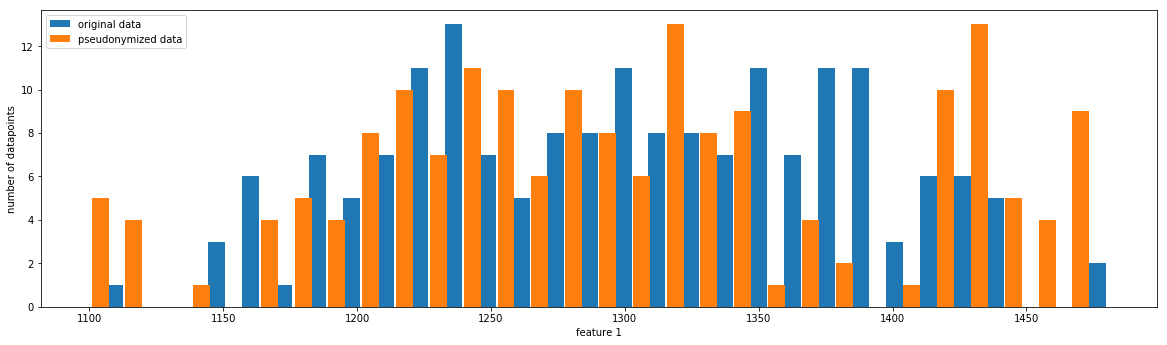

In [13]:
pl.figure(figsize=(20,12))
pl.subplot(211)
pl.hist(X['f1'], bins=30, rwidth=0.5, align='mid')
pl.hist(Xa['f1'], bins=30, rwidth=0.5, align='left');
pl.xlabel("feature 1")
pl.ylabel("number of datapoints")
pl.legend(["original data", "pseudonymized data"], loc='upper left')
pl.savefig("distribution-pseudonymized-original.pdf")

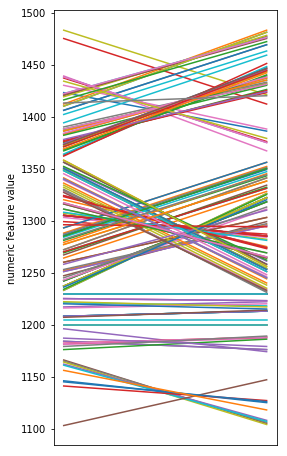

In [14]:
pl.figure(figsize=(4,8))
for i in range(len(X)):
    pl.plot([X.loc[i,"f1"], Xa.loc[i,"f1"]])
pl.xlabel("")
fr = pl.gca()
fr.axes.xaxis.set_visible(False)
pl.ylabel("numeric feature value")
pl.savefig("feature-value-before-after.pdf")